In [1]:
from os import path
import glob
import time

# Third-party
from astropy.table import Table, join, hstack
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm

import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

In [68]:
n_samples = 2048

## Classical dwarfs:

Source data: Helmi et al. 2018, Alan McConnachie's nearby galaxy catalog

In [69]:
helmi = Table.read('/Users/adrian/data/GaiaDR2/classical_dwarfs_helmi.txt', 
                   format='ascii.basic')
helmi_c = coord.SkyCoord(ra=helmi['ra']*u.deg, dec=helmi['dec']*u.deg)

mccon = Table.read('/Users/adrian/data/Misc/NearbyGalaxies.dat', 
                   format='ascii.basic')
mccon_c = coord.SkyCoord(ra=mccon['RA'], dec=mccon['Dec'], 
                         unit=(u.hourangle, u.degree))

idx, sep, _ = coord.match_coordinates_sky(helmi_c, mccon_c)
sep_mask = sep < 1*u.deg

dwarfs = hstack((mccon[idx[sep_mask]]['distmod', 'distmod_err_plus', 'distmod_err_minus'], 
                 helmi[sep_mask]))

rvs = [55.3, -291.0, 222.9, -246.9, 224.2,
       282.5, 78.0, 140.0, 111.4, 99.]

dwarfs_c = coord.SkyCoord(ra=dwarfs['ra']*u.deg,
                          dec=dwarfs['dec']*u.deg,
                          distance=coord.Distance(distmod=dwarfs['distmod']),
                          pm_ra_cosdec=dwarfs['pmra']*u.mas/u.yr,
                          pm_dec=dwarfs['pmdec']*u.mas/u.yr,
                          radial_velocity=rvs * u.km/u.s)

Mass references:
- Fnx: https://arxiv.org/abs/1807.07852
- Car, Scl, Sext: https://arxiv.org/abs/0901.0715
- ...

In [70]:
dwarfs_m = [1.25e8,
            3e7,
            2e7,
            1e7,
            4e7,
            1e7,
            1e7,
            1e7,
            3.1e7,
            1e7] * u.Msun

Draw samples from error distribution:

In [71]:
dms = np.random.normal(dwarfs['distmod'], dwarfs['distmod_err_plus'], 
                       size=(n_samples, len(dwarfs)))

Cov = np.zeros((len(dwarfs), 2, 2))
Cov[:, 0, 0] = dwarfs['pmra_error'] ** 2
Cov[:, 1, 1] = dwarfs['pmdec_error'] ** 2
Cov[:, 0, 1] = Cov[:, 1, 0] = dwarfs['pmra_pmdec_corr'] * dwarfs['pmra_error'] * dwarfs['pmdec_error']

mu = np.vstack((dwarfs['pmra'], dwarfs['pmdec'])).T
pms = np.stack([np.random.multivariate_normal(mu[i], Cov[i], n_samples) 
                for i in range(len(dwarfs))], axis=1)

dwarf_samples = coord.SkyCoord(ra=dwarfs['ra'][None] * u.deg,
                               dec=dwarfs['dec'][None] * u.deg,
                               distance=coord.Distance(distmod=dms),
                               pm_ra_cosdec=pms[..., 0]*u.mas/u.yr,
                               pm_dec=pms[..., 1]*u.mas/u.yr,
                               radial_velocity=np.random.normal(rvs, 5., (n_samples, len(dwarfs))) * u.km/u.s)

## Ultra-faints
Source data: Simon et al. 2018

In [72]:
simon1 = Table.read('/Users/adrian/data/GaiaDR2/ufds_simon_tbl1.csv')
simon2 = Table.read('/Users/adrian/data/GaiaDR2/ufds_simon_tbl2.csv')
simon = hstack((simon1, simon2))

simon_c = coord.SkyCoord(ra=simon['ra']*u.deg,
                         dec=simon['dec']*u.deg,
                         distance=simon['distance']*u.kpc,
                         pm_ra_cosdec=simon['pmra']*u.mas/u.yr,
                         pm_dec=simon['pmdec']*u.mas/u.yr,
                         radial_velocity=simon['radial_velocity']*u.km/u.s)

In [73]:
ufd_samples = coord.SkyCoord(ra=simon['ra'][None]*u.deg,
                             dec=simon['dec'][None]*u.deg,
                             distance=np.random.normal(simon['distance'],
                                                       simon['distance_error'],
                                                       (n_samples, len(simon)))*u.kpc,
                             pm_ra_cosdec=np.random.normal(simon['pmra'],
                                                           simon['pmra_error'],
                                                           (n_samples, len(simon)))*u.mas/u.yr,
                             pm_dec=np.random.normal(simon['pmdec'],
                                                     simon['pmdec_error'],
                                                     (n_samples, len(simon)))*u.mas/u.yr,
                             radial_velocity=np.random.normal(simon['radial_velocity'],
                                                              simon['radial_velocity_error'],
                                                              (n_samples, len(simon)))*u.km/u.s)

In [74]:
ufd_m = [1e7] * len(simon) * u.Msun # HACK

## Globular clusters:

In [75]:
baum_tbl = Table.read('/Users/adrian/data/Misc/Baumgardt-globclust.fits')
vasi_tbl = ascii.read('/Users/adrian/data/Misc/Vasiliev-globclust.txt', 
                      format='fixed_width')

ix1 = []
ix2 = []
for i, row in enumerate(baum_tbl):
    name = row['Name']
    
    # HACKS:
    if 'Ter' in name:
        name = name.replace('Ter', 'Terzan')
    elif 'Lil' in name:
        name = name.replace('Lil', 'Liller')
    elif name == 'ESO 452-SC11':
        name = 'ESO 452-11'
    
    for j, vrow in enumerate(vasi_tbl):
        if name in vrow['Name']:
            ix1.append(i)
            ix2.append(j)
            break
    else:
        print(name + ' not found')
            
ix1 = np.array(ix1)
ix2 = np.array(ix2)

tbl = hstack((baum_tbl[ix1], vasi_tbl[ix2]))

globs = tbl[np.isfinite(tbl['D']) & np.isfinite(tbl['Vlos'])]

globs_c = coord.SkyCoord(ra=globs['RA']*u.deg,
                         dec=globs['DEC']*u.deg,
                         distance=globs['D']*u.kpc,
                         pm_ra_cosdec=globs['PMRA']*u.mas/u.yr,
                         pm_dec=globs['PMDEC']*u.mas/u.yr,
                         radial_velocity=globs['Vlos']*u.km/u.s)

len(globs)

112

In [76]:
glob_samples = coord.SkyCoord(ra=globs['RA']*u.deg,
                              dec=globs['DEC']*u.deg,
                              distance=np.random.normal(globs['D'], 0.05*globs['D'], 
                                                        size=(n_samples, len(globs)))*u.kpc,
                              pm_ra_cosdec=np.random.normal(globs['PMRA'], globs['ePMRA'],
                                                            size=(n_samples, len(globs)))*u.mas/u.yr,
                              pm_dec=np.random.normal(globs['PMDEC'], globs['ePMDEC'],
                                                      size=(n_samples, len(globs)))*u.mas/u.yr,
                              radial_velocity=np.random.normal(globs['Vlos'], globs['eVlos'],
                                                               size=(n_samples, len(globs)))*u.km/u.s)

In [77]:
globs_m = globs['mass'] * u.Msun

---

In [124]:
mw_pot = gp.Hamiltonian(gp.load('../../gd1-dr2/output/mwpot.yml'))

# _pot = gp.CCompositePotential()
# _pot['disk'] = gp.MiyamotoNagaiPotential(m=7e10*u.Msun, a=3, b=0.28, 
#                                          units=galactic)
# _pot['halo'] = gp.NFWPotential(m=8e11, r_s=15.6, c=1, units=galactic)
# _pot['bulge'] = gp.HernquistPotential(m=4e9, c=1, units=galactic)
# mw_pot = gp.Hamiltonian(_pot)

gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

# corresponds to phi1=-40º, phi2~0º at present day
gd1_w0 = gd.PhaseSpacePosition(pos=[-12.68868135, -0.6431087,  6.07148769]*u.kpc,
                               vel=[-0.08122873, -0.24523054, -0.12486828]*u.kpc/u.Myr)

In [125]:
orbit_kw = dict(dt=-0.5*u.Myr, t1=0*u.Myr, t2=-2*u.Gyr)

gd1_orbit = mw_pot.integrate_orbit(gd1_w0, **orbit_kw)

min_drs = []
for c in [dwarf_samples, ufd_samples, glob_samples]:
    for j in range(c.shape[-1]):
#         mw_pot = gp.CCompositePotential()
#         mw_pot['disk'] = gp.MiyamotoNagaiPotential(m=np.random.normal(5.5, 0.5) * 1e10 * u.Msun,
#                                                    a=3, b=0.28, units=galactic)
#         mw_pot['bulge'] = gp.HernquistPotential(m=4e9, c=1, units=galactic)
#         mw_pot['halo'] = gp.NFWPotential(m=np.random.normal(7, 0.5) * 1e11,
#                                          r_s=np.random.normal(15.6, 0.3),
#                                          c=np.random.normal(0.95, 0.03), units=galactic)
#         mw_pot = gp.Hamiltonian(mw_pot)
        
        gc_w0 = gd.PhaseSpacePosition(c[:, j].transform_to(gc_frame).cartesian)
        orbits = mw_pot.integrate_orbit(gc_w0, **orbit_kw)
        min_dr = (orbits.pos - gd1_orbit.pos[:, None]).norm().min(axis=0)
        min_drs.append(min_dr)
min_drs = u.Quantity(min_drs)

In [126]:
def get_object_names(idx):
    n_dwarfs = len(dwarfs)
    n_ufds = len(simon)
    n_globs = len(globs)
    
    names = []
    for i in idx:
        if i < n_dwarfs:
            names.append(dwarfs[i]['name'])
        elif n_dwarfs < i < (n_dwarfs + n_ufds):
            names.append(simon[i - n_dwarfs]['name'])
        else:
            names.append(globs[i - n_dwarfs - n_ufds]['Name_1'])
            
    return np.array(names)

In [127]:
frac_come_close = (min_drs < (100*u.pc)).sum(axis=1) / min_drs.shape[1]

In [128]:
come_close_names = get_object_names(np.where((frac_come_close > 0))[0])

In [129]:
percentages = frac_come_close[frac_come_close > 0] * 100

In [130]:
come_close_names[np.argsort(percentages)[::-1]]

array(['NGC 6496', 'IC 4499', 'NGC 6584', 'Dra', 'NGC 5466', 'Pyxis', 'Sgr'],
      dtype='<U8')

In [131]:
percentages[np.argsort(percentages)[::-1]]

array([ 0.63476562,  0.1953125 ,  0.09765625,  0.09765625,  0.04882812,
        0.04882812,  0.04882812])

In [132]:
globs[globs['Name_1'] == 'NGC 6496']

Name_1,NRV,vr,chisqr,dist,mass,masstolight,r_c,r_hm,r_hl,logrho_c,logrho_hm,logT_RH,MF,sigma0,vesc,vr_err,mass_err,masstolight_err,Name_2,RA,DEC,D,Vlos,eVlos,PMRA,PMDEC,ePMRA,ePMDEC,corrPM,radius,Nmember
bytes12,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
NGC 6496,120,-134.7,0.65,11.69,106000.0,2.79,3.07,7.73,5.05,2.06,1.47,9.47,-0.75,3.4,12.2,0.3,16000.0,1.65,NGC 6496,269.765,-44.266,11.3,-134.7,0.3,-3.038,-9.221,0.008,0.007,0.053,6.0,1317


In [155]:
globs[globs['Name_1'] == 'IC 4499']

Name_1,NRV,vr,chisqr,dist,mass,masstolight,r_c,r_hm,r_hl,logrho_c,logrho_hm,logT_RH,MF,sigma0,vesc,vr_err,mass_err,masstolight_err,Name_2,RA,DEC,D,Vlos,eVlos,PMRA,PMDEC,ePMRA,ePMDEC,corrPM,radius,Nmember
bytes12,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
IC 4499,37,38.7,0.55,18.2,167000.0,2.25,5.3,14.84,9.83,1.47,0.8,10.06,-1.31,3.1,11.2,0.5,47000.0,0.78,IC 4499,225.077,-82.214,18.8,38.7,0.5,0.477,-0.495,0.006,0.007,0.134,6.0,1257


Is it distance error of pm error that dominates vtan error?

In [144]:
_pmra = np.random.normal(-3.038, 0.008, size=10000) * u.mas/u.yr
_pmdec = np.random.normal(-9.221, 0.007, size=10000) * u.mas/u.yr
_d = np.random.normal(11.3, 0.05*11.3, size=10000) * u.kpc
derps = (np.sqrt(_pmra**2 + _pmdec**2) * _d).to(u.km/u.s, u.dimensionless_angles()).value

Total hack to look at fractional error on distances:

(array([ 25.,  42.,  21.,  17.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.        ,  0.02966102,  0.05932203,  0.08898305,  0.11864407,
         0.14830508,  0.1779661 ,  0.20762712,  0.23728814,  0.26694915,
         0.29661017,  0.32627119,  0.3559322 ,  0.38559322,  0.41525424,
         0.44491525,  0.47457627,  0.50423729,  0.53389831,  0.56355932,
         0.59322034]),
 <a list of 20 Patch objects>)

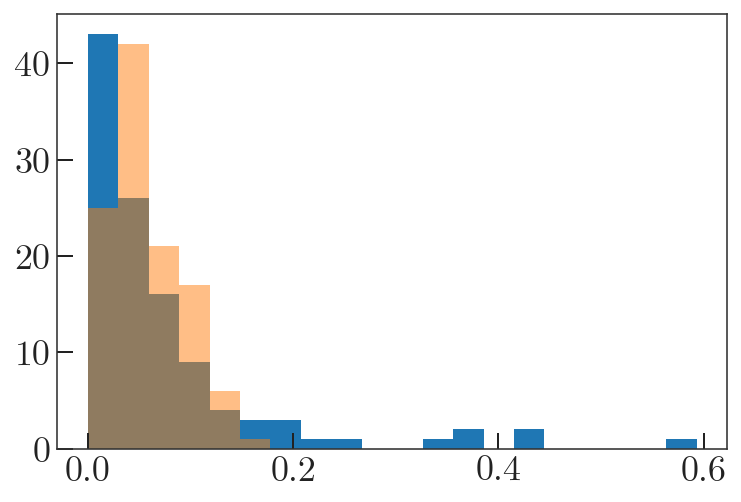

In [154]:
_, bins, _ = plt.hist(np.abs((globs['D'] - globs['dist'])/globs['D']), bins='auto')
plt.hist(np.abs(np.random.normal(0, 0.07, size=len(globs))), bins=bins, alpha=0.5)

---

## First reproduce Ana's figure

In [13]:
orbit_kw = dict(dt=-0.5*u.Myr, t1=0*u.Myr, t2=-2*u.Gyr)

In [14]:
from gala.dynamics import combine

In [15]:
all_orbits = []
for c in [dwarf_samples, ufd_samples, glob_samples]:
# for c in [dwarfs_c, simon_c, globs_c]:
    gc_w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    orbits = mw_pot.integrate_orbit(gc_w0, **orbit_kw)
    all_orbits.append(orbits)
    
orbits = combine(all_orbits)
masses = np.concatenate((dwarfs_m, ufd_m, globs_m)).value * u.Msun

In [264]:
gd1_orbit = mw_pot.integrate_orbit(gd1_w0, **orbit_kw)

mean_dr = (orbits.pos - gd1_orbit.pos[:, None]).norm()
mean_dv = (orbits.vel - gd1_orbit.vel[:, None]).norm()

mean_dr = mean_dr.reshape(len(orbits.t), -1, n_samples)
mean_dv = mean_dv.reshape(len(orbits.t), -1, n_samples)

mean_dr.shape

(4001, 139, 32)

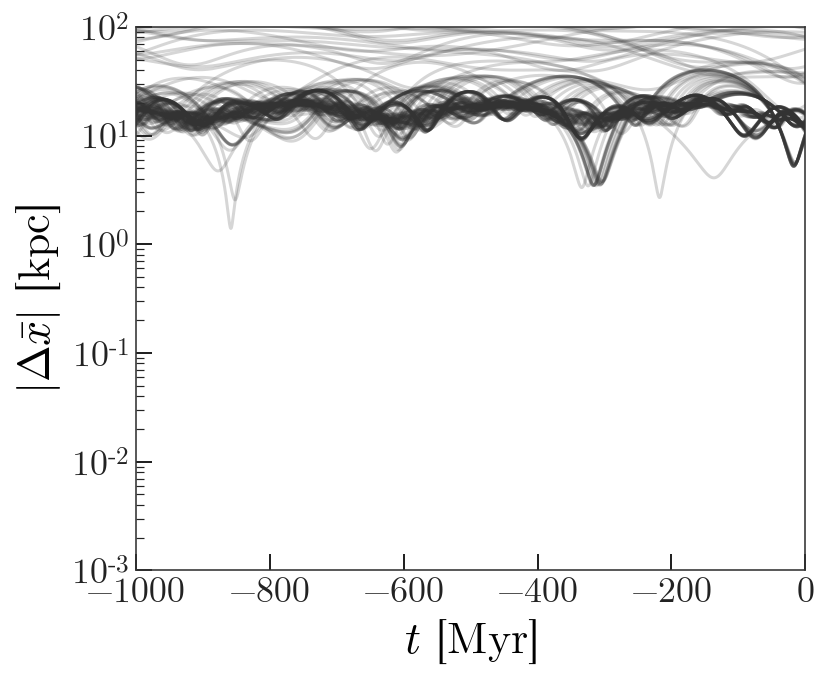

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(orbits.t, mean_dr[..., 0], 
# ax.plot(orbits.t, mean_dr, 
        marker='', color='#333333', alpha=0.2);

# squiggly line are the bulge globular clusters
# ax.plot(orbits.t, mean_dr[:, (gc_w0.pos.norm() < 4*u.kpc)], 
#         marker='', color='#333333', alpha=0.2);
ax.set_yscale('log')
ax.set_xlim(-1000, 0)
ax.set_ylim(1e-3, 1e2)
ax.set_xlabel('$t$ [Myr]')
ax.set_ylabel(r'$|\Delta \bar{x}|$ [kpc]')

fig.set_facecolor('w')

Text(0.5,0,'$t$ [Myr]')

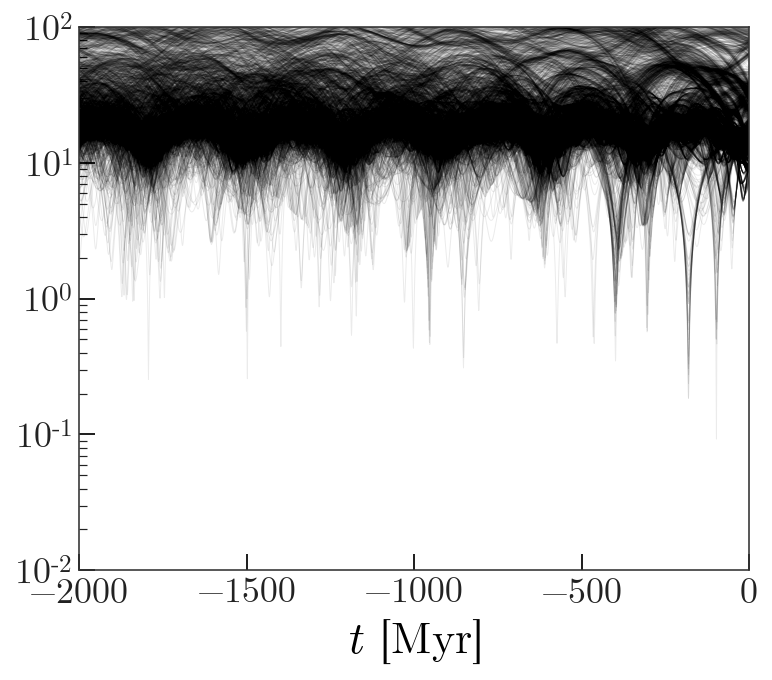

In [268]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for i in range(n_samples):
    ax.plot(orbits.t, mean_dr[..., i], marker='', 
            alpha=0.08, lw=0.5, color='k');

ax.set_yscale('log')
ax.set_xlim(-2000, 0)
ax.set_ylim(1e-2, 1e2)

ax.set_xlabel('$t$ [Myr]')
# ax.set_ylabel(r'$\frac{G M}{b V}$' + ' [{0:latex_inline}]'.format(u.km/u.s));

In [269]:
from astropy.constants import G
from scipy.signal import argrelmin

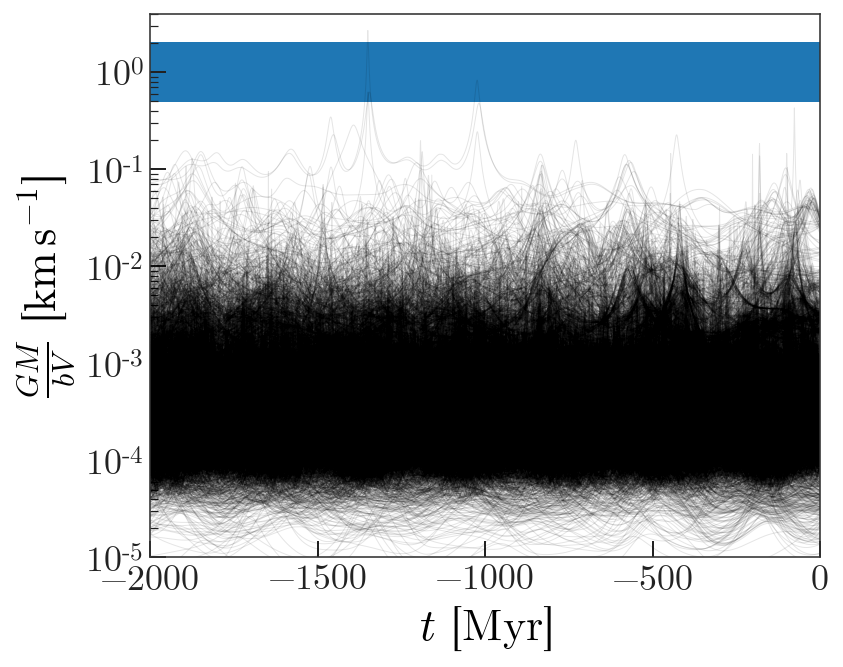

In [270]:
dv = G * masses[None, :, None] / (mean_dr * mean_dv)
dv = dv.to(u.km/u.s)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for i in range(n_samples):
    ax.plot(orbits.t, dv[..., i], marker='', 
            alpha=0.1, lw=0.5, color='k');

ax.set_yscale('log')
ax.set_xlim(-2000, 0)
ax.set_ylim(1e-5, 4e0)

ax.axhspan(0.5, 2, color='tab:blue')

ax.set_xlabel('$t$ [Myr]')
ax.set_ylabel(r'$\frac{G M}{b V}$' + ' [{0:latex_inline}]'.format(u.km/u.s));

---

In [42]:
bs = np.full((len(tbl), 32), np.nan) * u.kpc
dvs = np.full((len(tbl), 32), np.nan) * u.km/u.s
for i in range(len(tbl)):
    M = tbl['mass'][i] * u.Msun
    rs = mean_dr[:, i]
    vs = mean_dv[:, i]
    
    min_ix, = argrelmin(rs)
    
    b = rs[min_ix]
    V = vs[min_ix]
    
    dv = G * M / (b * V)
    
    bs[i, :len(dv)] = b
    dvs[i, :len(dv)] = dv.to(u.km/u.s)

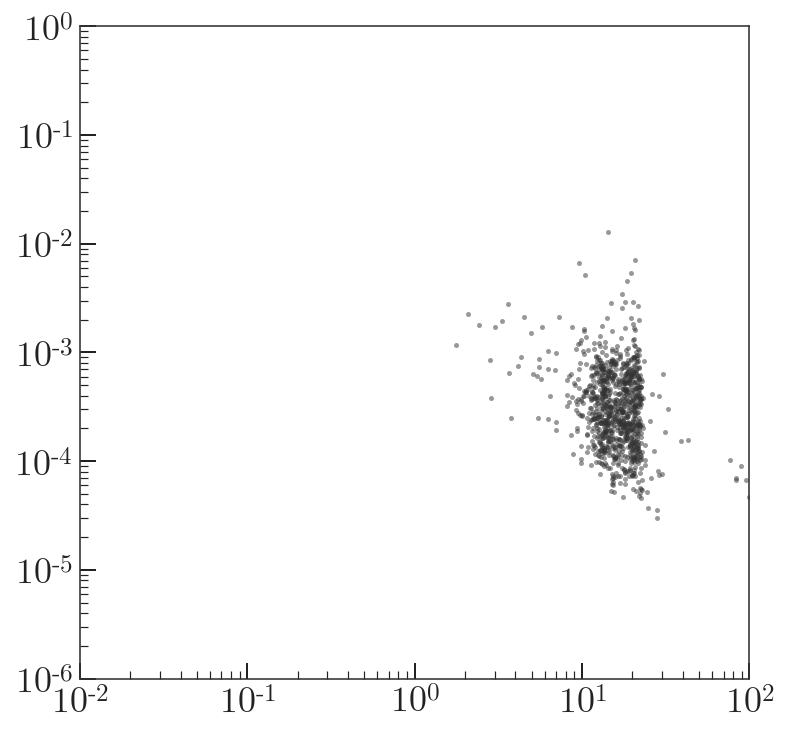

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(bs, dvs, 
        marker='.', color='#333333', alpha=0.5, ls='none');

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-2, 1e2)
ax.set_ylim(1e-6, 1e0)

# ax.set_xlabel('$t$ [Myr]')
# ax.set_ylabel(r'$|\Delta \bar{x}|$ [kpc]')

fig.set_facecolor('w')